There are some 1 minute draw profiles for US domestic hot water.  The data is from the BEopt. The data requires some cleaning and processing.  This data is used to provide input into the model.

In [ ]:
#| default_exp demand

In [5]:
#| hide
from nbdev.showdoc import *

In [6]:
#| export
import pandas as pd	
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path

In [7]:
#| export
def load_demand(path = None , bed=1,unit=1):
    if not (bed in [1, 2, 3, 4, 5]) and (unit in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
        print('Not valid bed / unit choice')
        return pd.DataFrame()
    base = pd.read_csv(path/'MinuteDrawProfilesMaxFlows.csv')
    df = pd.read_csv(path/f'DHWDrawSchedule_{bed}bed_unit{unit}_1min_fraction.csv')
    df = df.fillna(0)
    '''
    Translate between the BEOpt Data
    see https://github.com/jmaguire1/WaterHeaterPythonModel/blob/01f8a3c88096c9cbdbb49c354405d65fb37c2d7e/WH_control_fleet.py
    '''
    sh_hsp_tot = 14.0 + 4.67 * bed
    s_hsp_tot = 12.5 + 4.16 * bed
    cw_hsp_tot = 2.35 + 0.78 * bed
    dw_hsp_tot = 2.26 + 0.75 * bed
    b_hsp_tot = 3.50 + 1.17 * bed
    df.Showers =  base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'Showers Max'].values[0] * df.Showers * \
                    sh_hsp_tot / base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'Showers Sum'].values[0]
    df.Sinks =  base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'Sinks Max'].values[0] * df.Sinks * \
                    s_hsp_tot / base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'Sinks Sum'].values[0]
    df.CW =  base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'CW Max'].values[0] * df.CW * \
                    cw_hsp_tot / base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'CW Sum'].values[0]
    df.DW =  base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'DW Max'].values[0] * df.DW * \
                    dw_hsp_tot / base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'DW Sum'].values[0]
    df.Baths =  base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'Baths Max'].values[0] * df.Baths * \
                    b_hsp_tot / base.loc[((base.Bedrooms == bed) & (base.Unit== unit)),'Baths Sum'].values[0]
    # The flows can be split into hot and warm if more granular detail is required
    df = df * 3.785411784 # convert from US GPM to lpm
    df['total_lpm'] = df.sum(axis=1)
    df['total_m3s'] = df.total_lpm/60000
    df[f'flow'] = df.total_m3s
    df['timestamp'] = pd.date_range(start='1/1/2020', periods=len(df), freq='60S')
    df = df.set_index('timestamp')
    return df

In [8]:
flow = load_demand(path = Path('../data/drawprofiles'),
                      bed=4,
                      unit=3)
flow.head()

,Showers,Sinks,CW,DW,Baths,total_lpm,total_m3s,flow
timestamp,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Look at one days worth of data for the chosen unit and number of bedrooms.

In [9]:
# fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(flow['2020-01-01'])
# ax.set_ylabel('Flow (m3/s)')
# ax.set_xlabel('Time')
# ax.set_title('Flow for 2 bed 3 unit')

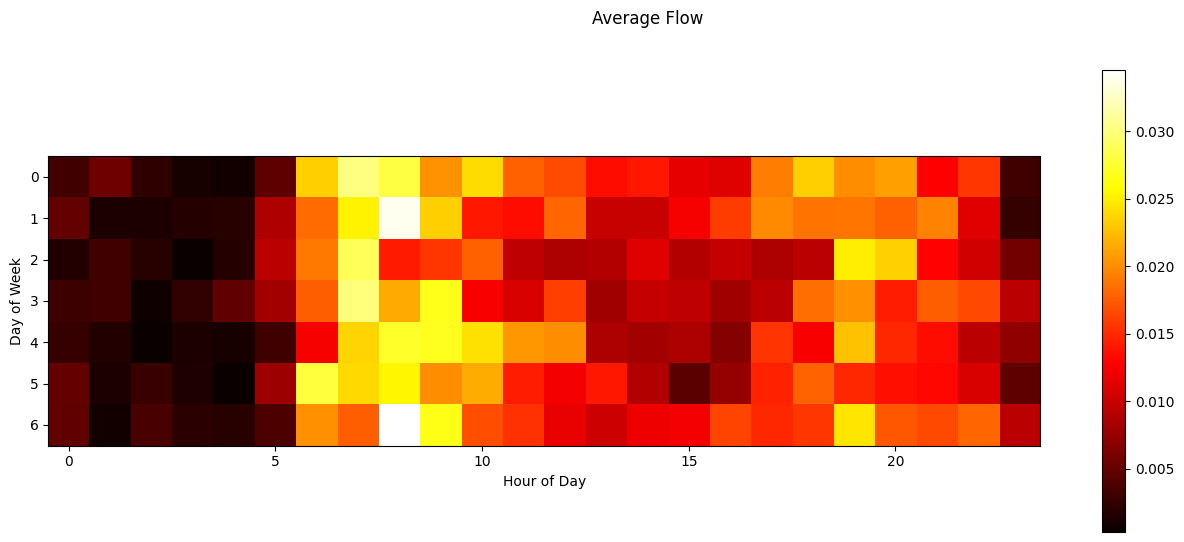

In [10]:
fig, ax = plt.subplots(figsize=(16,6))

ax.imshow(flow.groupby([flow.index.hour, flow.index.day_of_week])['flow'].mean().unstack().T*3600, cmap='hot', interpolation='nearest')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day of Week')
fig.suptitle('Average Flow')
# add colorbar
fig.colorbar(ax.get_images()[0], ax=ax)

In [11]:
#| hide
import nbdev; nbdev.nbdev_export()